In [118]:
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error as mape
import numpy as np
import pymc as pm
from scipy.stats import mode

from get_model_training_data_05 import get_features_and_data
from get_model_training_data_05 import weighted_absolute_percentage_error as wape

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (25, 15)})
sns.set(font_scale=2)
sns.set_style("ticks")

warnings.filterwarnings("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"

In [119]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Training and Testing Data

In [120]:
(df, train_df, test_df, feature_names, next_month) = get_features_and_data()

training examples = 2488, testing examples = 277


In [121]:
df.columns

Index(['index', 'days_since_previous_release', 'prob_of_release',
       'month_holidays', 'weekday', 'year', 'previous_release_post',
       'weekday_weight'],
      dtype='object')

In [122]:
# TODO: move this to get_features_and_data()
df["release"] = (df["prob_of_release"] == 1).astype(int)
train_df["release"] = (train_df["prob_of_release"] == 1).astype(int)
test_df["release"] = (test_df["prob_of_release"] == 1).astype(int)

In [123]:
weekday_in_year_id = {tuple(pair) : i for (i, pair) in enumerate(df[["weekday", "year"]].drop_duplicates().values)}
df["weekday_in_year_id"] = df.apply(lambda x : weekday_in_year_id[(x["weekday"], x["year"])], axis=1)
train_df["weekday_in_year_id"] = train_df.apply(lambda x : weekday_in_year_id[(x["weekday"], x["year"])], axis=1)
test_df["weekday_in_year_id"] = test_df.apply(lambda x : weekday_in_year_id[(x["weekday"], x["year"])], axis=1)

In [124]:
days_between_id = {tuple(pair) : i for (i, pair) in enumerate(
    df[["days_since_previous_release", "previous_release_post"]].drop_duplicates().values)}
df["days_between_id"] = df.apply(lambda x : days_between_id[(x["days_since_previous_release"], x["previous_release_post"])], axis=1)
train_df["days_between_id"] = train_df.apply(
    lambda x : days_between_id[(x["days_since_previous_release"], x["previous_release_post"])], axis=1)
test_df["days_between_id"] = test_df.apply(
    lambda x : days_between_id[(x["days_since_previous_release"], x["previous_release_post"])], axis=1)

## Model-Building and Evaluation

In [125]:
train_df = pandas.concat([train_df[train_df["release"] == 1], train_df.query('release == 0 & year >= 2022')],
                         ignore_index=True).sort_values(by=["index"])

In [126]:
train_df = train_df.set_index("index")
(obs_id, _) = train_df.index.factorize()

In [127]:
weekday_in_year_id = train_df["weekday_in_year_id"].values
days_between_id = train_df["days_between_id"].values

In [128]:
COORDS = {
    "weekday_in_year" : weekday_in_year_id,
    "days_between_id" : days_between_id,
    "observation" : obs_id,
}

In [129]:
with pm.Model(coords=COORDS) as model:
    weekday_in_year_effect = pm.Normal("weekday_in_year_effect", 0, 1, dims="weekday_in_year")
    sigma_mu = pm.HalfNormal("sigma_mu", 1)
    days_between_effect = pm.GaussianRandomWalk("days_between_effect", sigma=sigma_mu, dims="days_between_id")

    release_prob = pm.math.invlogit(
        days_between_effect[days_between_id] + weekday_in_year_effect[weekday_in_year_id]
    )

    release = pm.Bernoulli(
        "release",
        p=release_prob,
        observed=train_df["release"].values,
        dims="observation",
    )

In [130]:
with model:
    idata = pm.sample(1000, tune=1000, chains=4, random_seed=1024, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weekday_in_year_effect, sigma_mu, days_between_effect]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 106 seconds.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


### In-Sample Evaluation

In [131]:
with model:
    pred = pm.sample_posterior_predictive(idata, predictions=True, var_names=["release"])

Sampling: [release]


Output()

In [132]:
train_df["release_pred"] = [mode(p)[0] for p in pred["predictions"]["release"].stack(all_draws=["chain", "draw"]).values]

In [133]:
train_df["release_pred"].value_counts()

release_pred
0    654
1    291
Name: count, dtype: int64

In [134]:
train_df["release"].value_counts()

release
0    599
1    346
Name: count, dtype: int64

<Axes: ylabel='Count'>

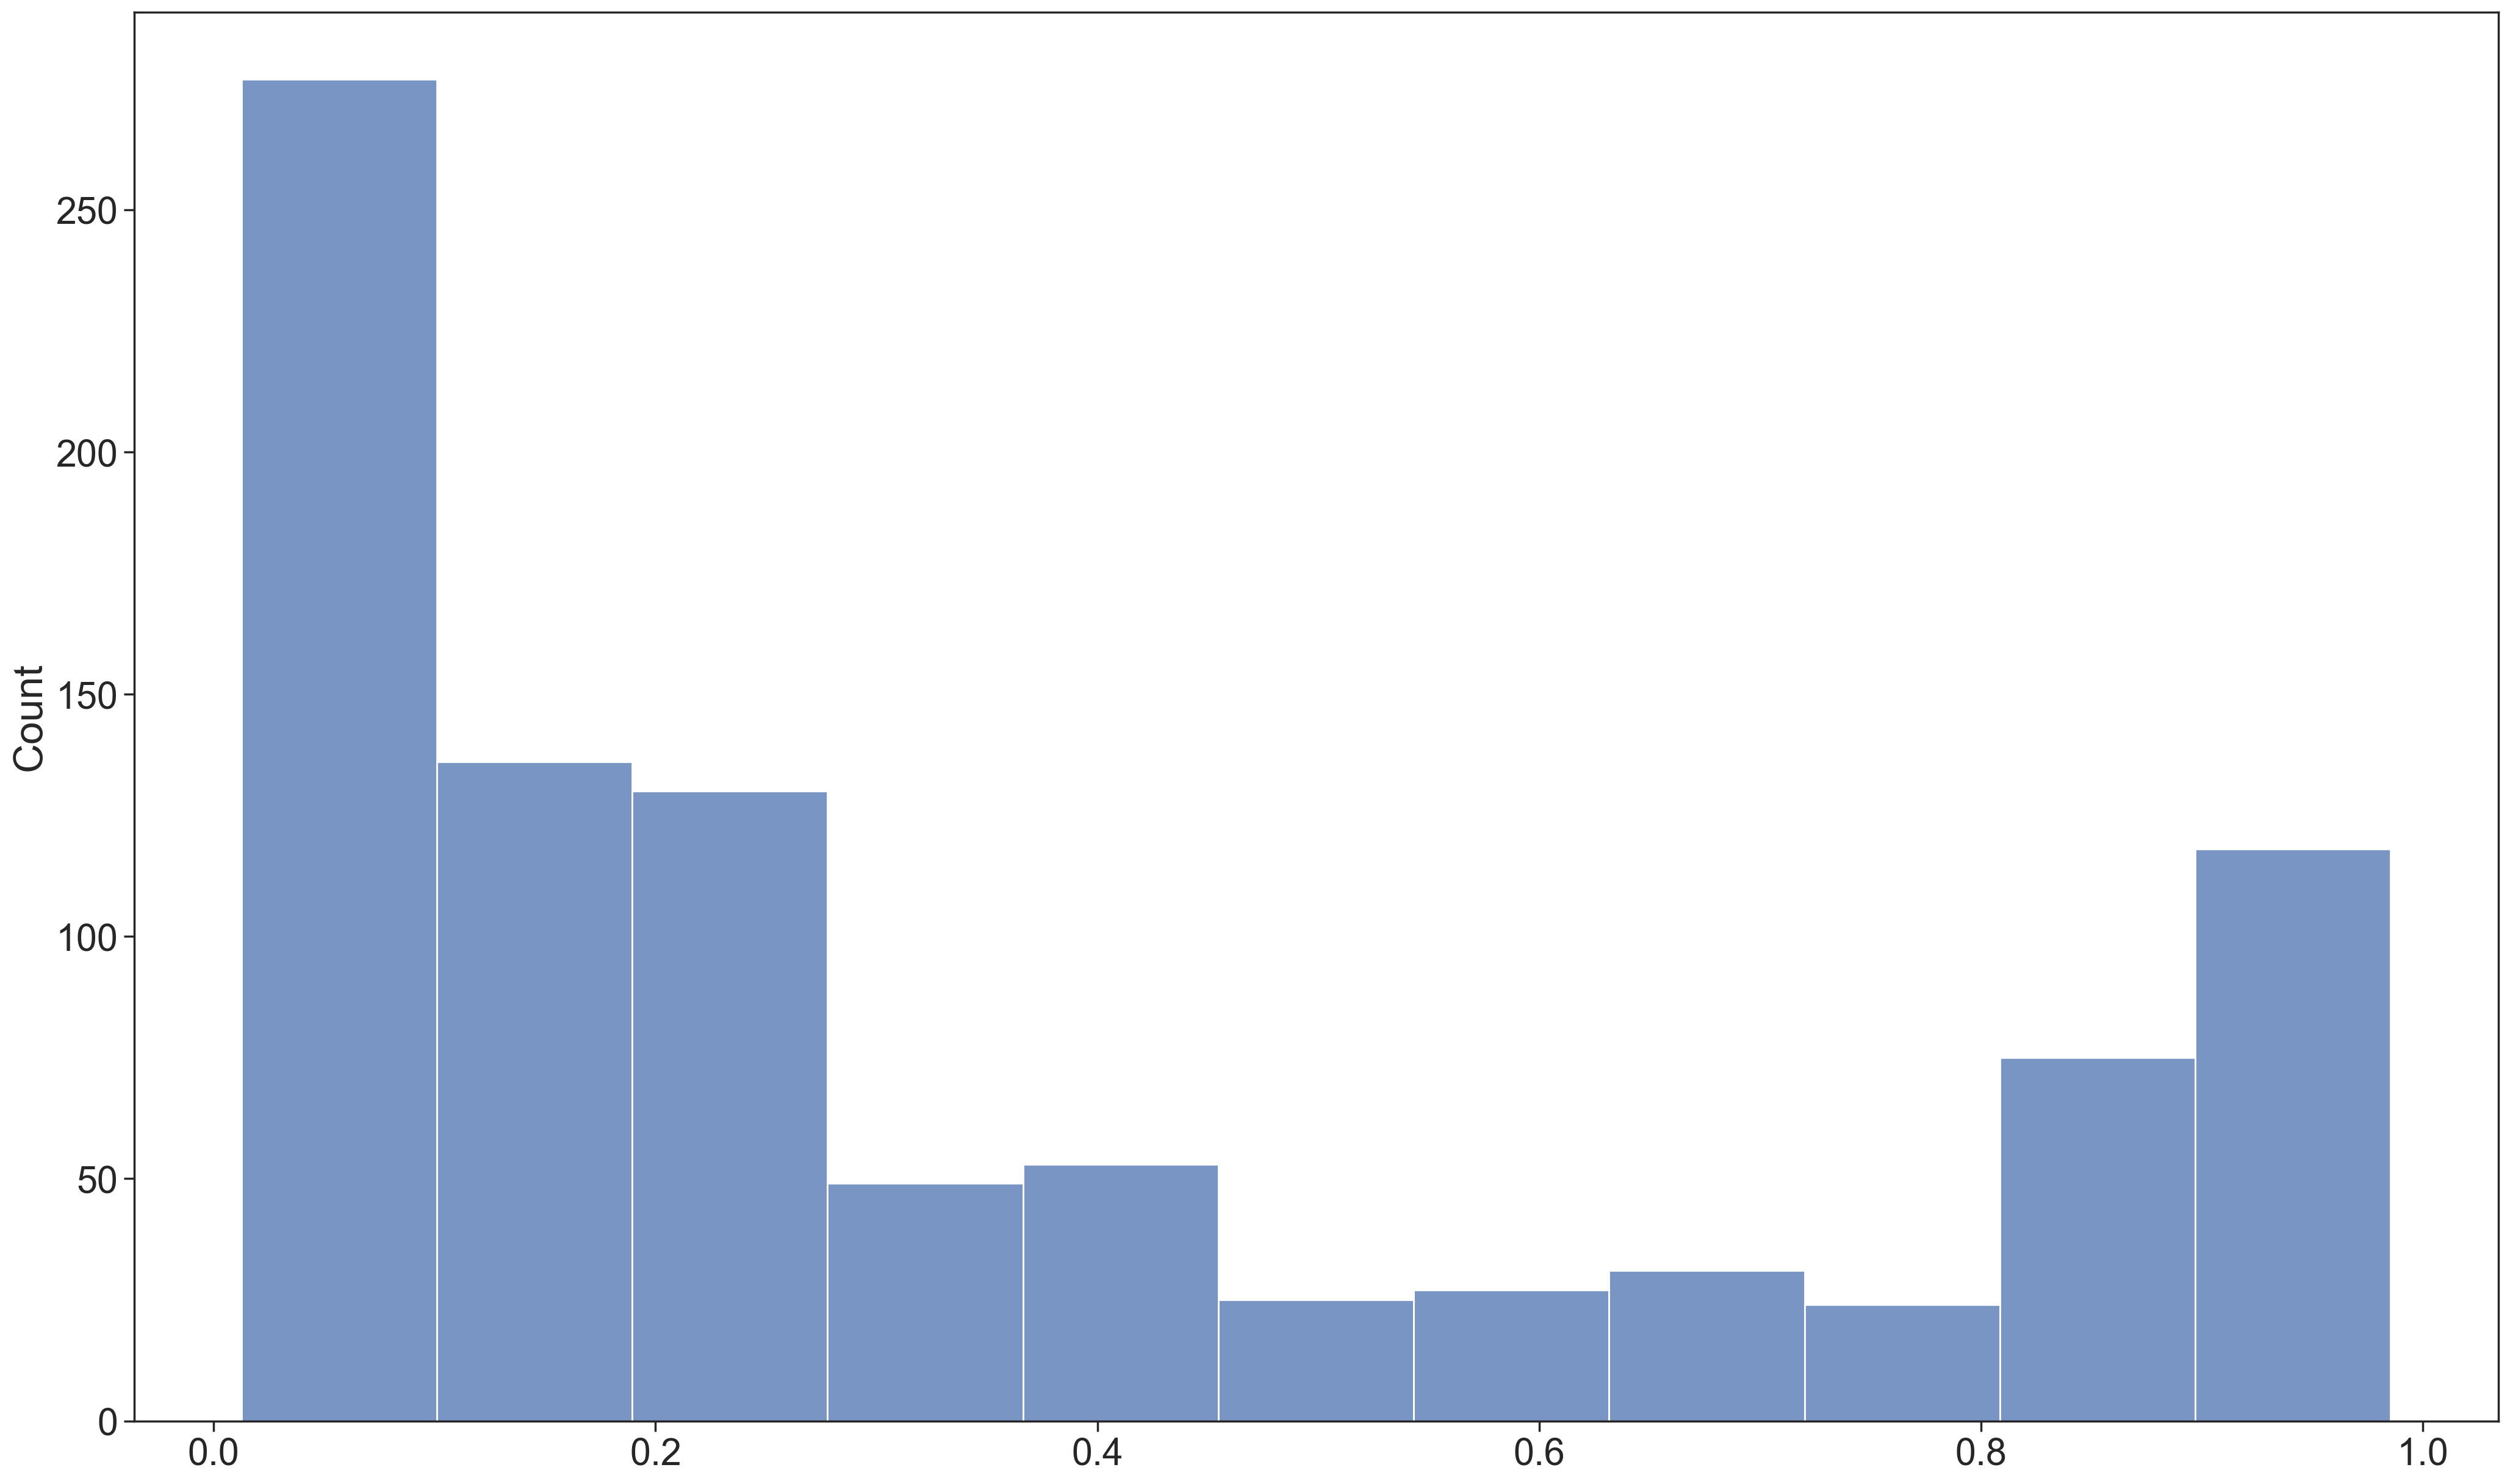

In [135]:
sns.histplot(x=np.mean(pred["predictions"]["release"].stack(all_draws=["chain", "draw"]).values, axis=1))

In [136]:
true_positives = len(train_df.query('release == 1 & release_pred == 1'))
false_positives = len(train_df.query('release != 1 & release_pred == 1'))
false_negatives = len(train_df.query('release == 1 & release_pred != 1'))

In [137]:
true_positives / (true_positives + false_positives)

0.9175257731958762

In [138]:
true_positives / (true_positives + false_negatives)

0.7716763005780347